This notebook shows how to use LLM-Geo, you can uncomment a study case (preferred Case 1 and Case 3) to get the spatial analysis results without any human intervention. 

Please check the [webpage of LLM-Geo](https://github.com/gladcolor/LLM-Geo) for more detail!


#  Install package

Make sure you are using the latest version of `openai` and `geopandas`.

In [1]:
# ! pip install pyvis
# ! pip install networkx
# ! pip install openai
# ! conda update  --channel conda-forge geopandas  


# Import package

In [2]:
import os
import sys
import requests
import networkx as nx
import pandas as pd
import geopandas as gpd
import rasterio
from pyvis.network import Network
from openai import OpenAI
from IPython.display import display, HTML, Code
from IPython.display import clear_output

# Define Solution class
Please run the following cell to define the functions

In [3]:
%load_ext autoreload
%autoreload 2

import LLM_Geo_Constants as constants
import helper

from LLM_Geo_kernel import Solution

sys.path.append(os.path.abspath("Modules"))    
import Modules.data_eye as data_eye

# Demonstration Cases

## Input task and data desciption

In [4]:
isReview = True

In [5]:

# Case 1: population living near hazardous wastes

# task_name ='Resident_at_risk_counting'
# TASK = r"""1) Find out Census tracts that contain hazardous waste facilities, then comppute and print out the population living in those tracts. The study area is North Carolina (NC), US.
# 2) Generate a population choropleth map for all tract polygons in NC, rendering the color by tract population; and then highlight the borders of tracts that have hazardous waste facilities. Please draw all polygons, not only the highlighted ones. The map size is 15*10 inches.
# """

# data location with column information
# DATA_LOCATIONS = ["NC hazardous waste facility ESRI shape file: https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/HW_Sites_EPSG4326.zip.",
#                   "NC tract boundary shapefile: https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/tract_37_EPSG4326.zip. The tract ID column is 'GEOID', data types is integer.",
#                   "NC tract population CSV file: https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/NC_tract_population.csv. The population is stored in 'TotalPopulation' column. The tract ID column is 'GEOID', data types is integer."
#                  ]

# data location without column information
# DATA_LOCATIONS = ["NC hazardous waste facility ESRI shape file: https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/HW_Sites_EPSG4326.zip.",
#                   "NC tract boundary shapefile: https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/tract_37_EPSG4326.zip.",
#                   "NC tract population CSV file: https://github.com/gladcolor/LLM-Geo/raw/master/overlay_analysis/NC_tract_population.csv."
#                  ]
 

# # Case 3: COVID-19 death rate in US
# task_name ='COVID_death_rate'
# TASK = r'''1) Draw a choropleth map to show the death rate (death/case) of COVID-19 among the countiguous US counties. Use the accumulated COVID-19 data of 2020.12.31 to compute the death rate. Use scheme ='quantiles' when plotting the map.  Set map projection to 'Conus Albers'. Set map size to 15*10 inches.  
# 2) Draw a scatter plot to show the correlation and trend line of the death rate with the senior resident rate, including the r-square and p-value. Set data point transparency to 50%, regression line as red. Set figure size to 15*10 inches.  
# '''

# data location with column information
# DATA_LOCATIONS = [
#                   r"COVID-19 data case in 2020 (county-level): https://github.com/nytimes/covid-19-data/raw/master/us-counties-2020.csv. This data is for daily accumulated COVID cases and deaths for each county in the US. There are 5 columns: date (format: 2021-02-01), county, state, fips, cases, deaths. ",   
#                   r"Contiguous US county boundary (ESRI shapefile): https://github.com/gladcolor/spatial_data/raw/master/contiguous_counties.zip. The county FIPS column is 'GEOID'; map projection is EPSG:4269",
#                   r"Census data (ACS2020): https://raw.githubusercontent.com/gladcolor/spatial_data/master/Demography/ACS2020_5year_county.csv. THe needed columns are: 'FIPS', 'Total Population', 'Total Population: 65 to 74 Years', 'Total Population: 75 to 84 Years', 'Total Population: 85 Years and Over'. Drop rows with NaN cells after loading the used columns.",
#                  ]

# data location without column information
# DATA_LOCATIONS = [
#                   r"COVID-19 data case in 2020 (county-level): https://github.com/nytimes/covid-19-data/raw/master/us-counties-2020.csv. This data is for daily accumulated COVID cases and deaths for each county in the US. ",   
#                   r"Contiguous US county boundary (ESRI shapefile): https://github.com/gladcolor/spatial_data/raw/master/contiguous_counties.zip.",
#                   r"Census data (ACS2020): https://raw.githubusercontent.com/gladcolor/spatial_data/master/Demography/ACS2020_5year_county.csv. "
#                  ]

# # Case 4: Hospital_accessibility
# task_name ='Hospital_accessibility'
# TASK = r'''
# For each zipcode area in South Carolina (SC), calculate the distance from the centroid of the zipcode area to its nearest hospital, and then create a choropleth distance map of zipcode area polygons (unit: km), also show the hospital.
# '''

## data location with column information
# DATA_LOCATIONS = [
# r"SC zipcode boundary shapefile: https://github.com/GIBDUSC/test/raw/master/sc_zip_boundary.zip, the map projection is WGS1984.",
# r"SC hospitals:  https://github.com/gladcolor/spatial_data/raw/master/South_Carolina/SC_hospitals_with_emergency_room_cleaned.csv, location columns: longitude in 'Longitude' column, latitude in 'Latitude' column.",          
# ]

# data location without column information
# DATA_LOCATIONS = [
# r"SC zipcode boundary shapefile: https://github.com/GIBDUSC/test/raw/master/sc_zip_boundary.zip.",
# r"SC hospitals:  https://github.com/gladcolor/spatial_data/raw/master/South_Carolina/SC_hospitals_with_emergency_room_cleaned.csv.",          
# ]

# # Case 5: school walkability
# task_name ='School walkability'
# TASK = r'''You need to compute the walkability scores for all schools in the Colubmia city. The steps are:
# 1) extract the road network near a school within 1 km buffer zone.
# 2) extract the sidewalks within 20 meters to the extracted road network in the step 1.
# 3) the school walkability scores is the ratio of the extracted sidewalk length to the extracted road network length.
# 4) Please draw a map for each school, using the school name and the walkability score as the map title, while showing the extracted sidewalks on a OpenStreetMap basemap.
# '''

# data location with column information
DATA_LOCATIONS = [
r"Columbia school points: https://github.com/gladcolor/spatial_data/raw/refs/heads/master/South_Carolina/Columbia_schools.gpkg.",
r"Columbia road network (polyline): https://github.com/gladcolor/spatial_data/raw/refs/heads/master/South_Carolina/Columbia_road.gpkg.",          
r"Columbia sidewalk network (polyline): https://github.com/gladcolor/spatial_data/raw/refs/heads/master/South_Carolina/Columbia_sidewalks.gpkg."    
]

##  Case 6: Trunk diameter error
# task_name = "Trunk diameter error"
# TASK = """You need to compute the location error between the estimated tree trunk and the ground truth: 
# 1) for each ground truth location, find out its nearest estimated location within 3 meters. 
# 2) compute the RMSE for ground truth trunks that have the associated estimated location."
# """

# DATA_LOCATIONS = [
# r"Estimated trunk location: D:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Data\Street_view_image\trunk_location_estimated_EPSG6569.shp.", 
# r"Trunk ground truth: D:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Data\Street_view_image\trunk_location_ground_truth_EPSG6569.shp."
# ]

##  Case 7: Population difference
# task_name = "Population difference"
# TASK = """Make a thematic map, show the difference between the resident population data and the LandScan gridded nighttime population for the Census tracts in North Carolina. 
# """
# DATA_LOCATIONS = [
# r"North Carolina Census tract boundaris: D:/OneDrive_PSU/OneDrive - The Pennsylvania State University/Data/LandScan/North_Carolina_tracts.shp", 
# r"USA residential population at block group level: D:/OneDrive_PSU/OneDrive - The Pennsylvania State University/Data/LandScan/Residential_population.csv",
# r"USA LandScan nighttime population at block group level: D:/OneDrive_PSU/OneDrive - The Pennsylvania State University/Data/LandScan/landscan-usa-2021-night.csv"
# ]


##  Case 8: Store site selection
# task_name = "Store site selection"
# TASK = """Propose a new Walmart store location, which has similar distances to the existing four locations, while near the roads within 300 meters.
# """

# DATA_LOCATIONS = [
# r"Existing Walmart locations: D:/OneDrive_PSU/OneDrive - The Pennsylvania State University/Data/Walmart_site/Walmart_4_site_EPSG32111.shp", 
# r"Road network: D:/OneDrive_PSU/OneDrive - The Pennsylvania State University/Data/Walmart_site/Motorway_EPSG32111.shp",
# ]

##  Case 9: random points
task_name = "Random points"
TASK = """You have a point layer, and need to do: inside the extent of this layer, generate as much as possible random points that with a minimum distance of 100 m, while with a minimum distance of 30 m to the given points. 
"""

DATA_LOCATIONS = [
r"D:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Data\Street_tree\Richland_downtown_street_view_image_location.shp",
]


# # Case 2: France_mobility_changes_2020  (NOTE: invalidated due to API shutdown)
# task_name ='France_mobility_changes_2020'
# TASK = r'''
# 1) Show the 2020 human mobility monthly change rates of each administrative regions in a France choropleth map. Each month is a sub-map in a map matrix，12 months in total. All monthly maps need to use the same colorbar range (color scheme: coolwarm). The base of the change rate is January 2020. 
# 2) Draw a line chart to show the monthly change rate trends of all administrative regeions. Each region is a line (the region name is the legend), the x-axis is 2020 months.
# '''

# DATA_LOCATIONS = ["ESRI shapefile for France administrative regions:" + \
#                   "https://github.com/gladcolor/LLM-Geo/raw/master/REST_API/France.zip. " + \
#                   "The 'GID_1' column is the administrative region code, 'NAME_1' column is the administrative region name.",
#                   "REST API url with parameters for daily human mobility data access:" + \
#                   "http://gis.cas.sc.edu/GeoAnalytics/REST?operation=get_daily_movement_for_all_places&source=twitter&scale=world_first_level_admin&begin=01/01/2020&end=12/31/2020." + \
#                   "The response is in CSV format. There are three columns in the response: " + \
#                   "place,date (format:2020-01-07), and intra_movement. 'place' column is the administractive region code of every country;" + \
#                   "codes for France administrative regions start with 'FRA'. Use the total intra_movement of the month as the montly mobility.",
#                  ]


save_dir = os.path.join(os.getcwd(), task_name)
os.makedirs(save_dir, exist_ok=True)

# create graph
# model = r'gpt-4o'
model = r'gpt-4o-2024-08-06'


In [6]:
# file_path = r'https://github.com/gladcolor/spatial_data/raw/refs/heads/master/Everest_DEM.tif'
# file_path = r'https://github.com/gladcolor/spatial_data/raw/refs/heads/master/Everest_DOM.tif'
# file_path = r"D:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\LLM_Geo\QGIS_plugin\sentinel2.tif"
# file_path = r"C:\Users\A\Downloads\Sentinel_downloaded\L1C_T31TBF_A043377_20231012T105229_2023-10-12\L1C_T31TBF_A043377_20231012T105229_B09.jp2"

## Get data overview (column names, data types, and map projection)

In [7]:
attributes_json, DATA_LOCATIONS = data_eye.add_data_overview_to_data_location(task=TASK, data_location_list=DATA_LOCATIONS, model=model)
print("DATA_LOCATIONS with data overviews:")
print(DATA_LOCATIONS)

DATA_LOCATIONS with data overviews:
["D:\\OneDrive_PSU\\OneDrive - The Pennsylvania State University\\Data\\Street_tree\\Richland_downtown_street_view_image_location.shpD:\\OneDrive_PSU\\OneDrive - The Pennsylvania State University\\Data\\Street_tree\\Richland_downtown_street_view_image_location.shp Data overview: {'column names and data types': 'column names, data types, and sample values (column_name: data_type, sample value |):[panoId: object, u_A-IR-jZgf1hDl9JOtPgA]', 'Coordinate reference system': 'EPSG:6569'}"]


In [8]:
solution = Solution(
                    task=TASK,
                    task_name=task_name,
                    save_dir=save_dir,
                    data_locations=DATA_LOCATIONS,
                    model=model,
                    )
print("Prompt to get solution graph:\n")
print(solution.graph_prompt)

Prompt to get solution graph:

Your role: A professional Geo-information scientist and programmer good at Python. You have worked on Geographic information science more than 20 years, and know every detail and pitfall when processing spatial data and coding. You know well how to set up workflows for spatial analysis tasks. You have significant experence on graph theory, application, and implementation. You are also experienced on generating map using Matplotlib and GeoPandas.
 

Your task: Generate a graph (data structure) only, whose nodes are (1) a series of consecutive steps and (2) data to solve this question:  
 You have a point layer, and need to do: inside the extent of this layer, generate as much as possible random points that with a minimum distance of 100 m, while with a minimum distance of 30 m to the given points. 
 

Your reply needs to meet these requirements: 
 1. Think step by step.
2. Steps and data (both input and output) form a graph stored in NetworkX. Disconnected

## Get graph code from GPT API

In [9]:
response_for_graph = solution.get_LLM_response_for_graph() 
solution.graph_response = response_for_graph
solution.save_solution()

clear_output(wait=True)
display(Code(solution.code_for_graph, language='python'))

import networkx as nx

# Create a directed graph
G = nx.DiGraph()

# 1. Load the point layer shapefile
G.add_node("point_layer_shp", node_type="data", data_path="D:\\OneDrive_PSU\\OneDrive - The Pennsylvania State University\\Data\\Street_tree\\Richland_downtown_street_view_image_location.shp", description="Point layer shapefile of Richland downtown street view image locations")
G.add_node("load_point_layer", node_type="operation", description="Load the point layer shapefile into a GeoDataFrame")
G.add_edge("point_layer_shp", "load_point_layer")

# 2. Convert the shapefile to GeoDataFrame
G.add_node("point_layer_gdf", node_type="data", data_path="", description="GeoDataFrame of the point layer")
G.add_edge("load_point_layer", "point_layer_gdf")

# 3. Get the extent of the point layer
G.add_node("get_extent_operation", node_type="operation", description="Calculate the extent (boundary box) of the point layer")
G.add_edge("point_layer_gdf", "get_extent_operation")

# 4. Boundary extent
G.add_node("boundary_extent", node_type="data", data_path="", description="Extent of the point layer as a geometry object")
G.add_edge("get_extent_operation", "boundary_extent")

# 5. Generate random points inside the extent
G.add_node("generate_random_points_operation", node_type="operation", description="Generate random points within the extent with constraints")
G.add_edge("boundary_extent", "generate_random_points_operation")
G.add_edge("point_layer_gdf", "generate_random_points_operation")

# 6. Generated random points
G.add_node("random_points", node_type="data", data_path="", description="Random points with a minimum distance of 100m from each other and 30m from given points")
G.add_edge("generate_random_points_operation", "random_points")

# Save graph to GraphML
nx.write_graphml(G, "D:\\OneDrive_PSU\\OneDrive - The Pennsylvania State University\\Research_doc\\LLM_Geo\\Python_code\\Random points\\Random points.graphml")

## Execute code to generate the solution graph

In [10]:
exec(solution.code_for_graph)
solution_graph = solution.load_graph_file()

# Show the graph
G = nx.read_graphml(solution.graph_file)  
nt = helper.show_graph(G)
html_name = os.path.join(os.getcwd(), solution.task_name + '.html')  
# HTML file should in the same directory. See:
# https://stackoverflow.com/questions/65564916/error-displaying-pyvis-html-inside-jupyter-lab-cell
nt.show(name=html_name)
# html_name

 

D:\OneDrive_PSU\OneDrive - The Pennsylvania State University\Research_doc\LLM_Geo\Python_code\Random points.html


## Generate prompts and code for operations (functions)

In [11]:
operations = solution.get_LLM_responses_for_operations(review=isReview)
solution.save_solution()

all_operation_code_str = '\n'.join([operation['operation_code'] for operation in operations])

clear_output(wait=True)
display(Code(all_operation_code_str, language='python'))

import geopandas as gpd

def load_point_layer(point_layer_shp='D:\\OneDrive_PSU\\OneDrive - The Pennsylvania State University\\Data\\Street_tree\\Richland_downtown_street_view_image_location.shp'):
    # Description: Load the point layer shapefile into a GeoDataFrame
    point_layer_gdf = gpd.read_file(point_layer_shp)
    return point_layer_gdf
def get_extent_operation(point_layer_gdf):
    # Description: Calculate the extent (boundary box) of the point layer
    # Drop records with NaN geometries before further processing
    point_layer_gdf = point_layer_gdf.dropna(subset=['geometry'])
    
    # Calculate the bounding box as a GeoSeries object
    boundary_extent = point_layer_gdf.total_bounds
    
    return boundary_extent
import geopandas as gpd
from shapely.geometry import Point, Polygon
import numpy as np

def generate_random_points_operation(point_layer_gdf=point_layer_gdf, boundary_extent=boundary_extent):
    # Description: Generate random points within the extent with constraints
    
    # Ensure the CRS is consistent for distance calculations (using the same CRS as point_layer_gdf)
    crs = point_layer_gdf.crs
    
    # Extract the boundary coordinates
    minx, miny, maxx, maxy = boundary_extent
    
    # Initialize a GeoDataFrame to store random points
    random_points_gdf = gpd.GeoDataFrame(columns=['geometry'], crs=crs)
    
    # Define distances
    min_distance = 30  # Minimum distance from existing points in meters
    point_distance = 100  # Minimum distance between new points in meters
    
    def is_valid_point(test_point):
        """Check if the test point satisfies the distance constraints"""
        # Check distance to existing points
        existing_distance_constraint = point_layer_gdf.distance(test_point).min() >= min_distance
        
        # Check distance to already placed random points
        if not random_points_gdf.empty:
            random_distance_constraint = random_points_gdf.distance(test_point).min() >= point_distance
        else:
            random_distance_constraint = True
            
        return existing_distance_constraint and random_distance_constraint
    
    # Generate points until a maximum attempt or sufficient points are placed
    max_attempts = 10000
    attempt = 0
    while attempt < max_attempts:
        # Generate a random point
        x = np.random.uniform(minx, maxx)
        y = np.random.uniform(miny, maxy)
        random_point = Point(x, y)
        
        # Validate the point
        if is_valid_point(random_point):
            random_points_gdf = random_points_gdf.append({'geometry': random_point}, ignore_index=True)
            
        attempt += 1
    
    return random_points_gdf

## Generate prompts and code for assembly program

In [12]:
assembly_LLM_response = solution.get_LLM_assembly_response(review=isReview)
solution.assembly_LLM_response = assembly_LLM_response
solution.save_solution()

clear_output(wait=True)
display(Code(solution.code_for_assembly, language='python'))

import geopandas as gpd
from shapely.geometry import Point
import numpy as np
import matplotlib.pyplot as plt

def load_point_layer(point_layer_shp='D:\\OneDrive_PSU\\OneDrive - The Pennsylvania State University\\Data\\Street_tree\\Richland_downtown_street_view_image_location.shp'):
    # Load the point layer shapefile into a GeoDataFrame
    point_layer_gdf = gpd.read_file(point_layer_shp)
    return point_layer_gdf

def get_extent_operation(point_layer_gdf):
    # Calculate the extent (bounding box) of the point layer
    point_layer_gdf = point_layer_gdf.dropna(subset=['geometry'])
    boundary_extent = point_layer_gdf.total_bounds
    return boundary_extent

def generate_random_points_operation(point_layer_gdf, boundary_extent):
    # Generate random points within the extent with constraints
    crs = point_layer_gdf.crs
    minx, miny, maxx, maxy = boundary_extent
    
    random_points_gdf = gpd.GeoDataFrame(columns=['geometry'], crs=crs)
    min_distance = 30
    point_distance = 100

    def is_valid_point(test_point):
        # Check if the test point satisfies the distance constraints
        existing_distance_constraint = point_layer_gdf.distance(test_point).min() >= min_distance
        if not random_points_gdf.empty:
            random_distance_constraint = random_points_gdf.distance(test_point).min() >= point_distance
        else:
            random_distance_constraint = True
        return existing_distance_constraint and random_distance_constraint

    max_attempts = 10000
    attempt = 0
    while attempt < max_attempts:
        x = np.random.uniform(minx, maxx)
        y = np.random.uniform(miny, maxy)
        random_point = Point(x, y)
        
        if is_valid_point(random_point):
            random_points_gdf = random_points_gdf.append({'geometry': random_point}, ignore_index=True)
        
        attempt += 1
    
    return random_points_gdf

def plot_and_save_random_points(point_layer_gdf, random_points_gdf, filepath='random_points_map.png'):
    # Plot given and random points, and save the map as an image
    base = point_layer_gdf.plot(color='blue', marker='o', label='Given Points')
    random_points_gdf.plot(ax=base, color='red', marker='x', label='Random Points')
    plt.legend()
    plt.title('Random Points Generation')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.savefig(filepath)

def assembly_solution():
    point_layer_gdf = load_point_layer()
    boundary_extent = get_extent_operation(point_layer_gdf)
    random_points_gdf = generate_random_points_operation(point_layer_gdf, boundary_extent)
    plot_and_save_random_points(point_layer_gdf, random_points_gdf)

assembly_solution()

## Execute assembly code



-------------- Running code (trial # 1/10) --------------


Error_info_str: 
Traceback (most recent call last):
  File "Complete program", line 20, in <module>
    def generate_random_points_operation(point_layer_gdf=point_layer_gdf, boundary_extent=boundary_extent):
NameError: name 'point_layer_gdf' is not defined

Sending error information to LLM for debugging...
Let's address the issues in the provided code and correct any mistakes.

1. **Correct Imports and Redefinitions**: There are redundant imports and the definition of functions multiple times. We will clean this up.
2. **Variable Definitions**: The error was caused because the variables `point_layer_gdf` and `boundary_extent` were being used in the function signature before being initialized. This can be fixed by ensuring these values are explicitly passed when calling the function.
3. **CRS Handling**: Since we're using distances, it's appropriate to ensure the CRS allows for metric calculations, although the data seems to 

<Figure size 1080x720 with 0 Axes>

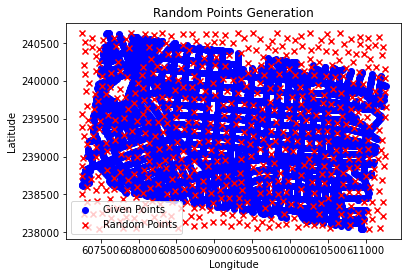

In [13]:
all_code = all_operation_code_str + '\n' + solution.code_for_assembly

# display(Code(all_code, language='python'))

all_code = solution.execute_complete_program(code=all_code, try_cnt=10)